### This version adds the part for user initial  set up 

In [1]:
#pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install flask-restful

    100% |████████████████████████████████| 51kB 2.0MB/s ta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [3]:
#For SSL certificate
#!pip install -U pyOpenSSL

    100% |████████████████████████████████| 61kB 1.3MB/s ta 0:00:01
    100% |████████████████████████████████| 1.6MB 3.6MB/s ta 0:00:011
  Found existing installation: cryptography 2.6.1
    Uninstalling cryptography-2.6.1:
      Successfully uninstalled cryptography-2.6.1
  Found existing installation: pyOpenSSL 19.0.0
    Uninstalling pyOpenSSL-19.0.0:
      Successfully uninstalled pyOpenSSL-19.0.0


In [9]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
#from scipy import integrate
import statistics as stats
#import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import sys
from geopy.geocoders import Nominatim
from geopy import distance
from geopy import Point
import statistics 
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
#Resource allows more segreggated 
from flask import Flask, request
from flask_restful import Resource, Api
from sqlalchemy import create_engine
from json import dumps
from flask import jsonify
import json
import requests
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('notebook', {'highlight_selected_word': {
    'delay': 500,
    'highlight_across_all_cells': True,
}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'load_extensions': {'nbextensions_configurator/config_menu/main': True,
  'contrib_nbextensions_help_item/main': True,
  'hinterland/main': True,
  'hinterland': True,
  'codefolding/main': True,
  'highlight_selected_word/main': True,
  'code_prettify/code_prettify': True},
 'highlight_selected_word': {'delay': 500, 'highlight_across_all_cells': True}}

## Dataset files 

In [11]:
### import explanation data and store it in the df_explanation file
TorontoExplanation = "../data/Toronto_explanation.json"
with open(TorontoExplanation,'r') as f:
    data = f.readlines()
    data = list(map(json.loads, data))
data = data[0]
#Get all the data from the dggeata file
df_explanation = pd.DataFrame(data)

### Popularity Calculation

In [12]:
def get_three_popularity_matrix(df_original,rtrain):
    # get the list of popular items by ranking the number of reviews
    numUsers = rtrain.shape[0]
    numItems = rtrain.shape[1]
    
    dff_popular = df_original.copy()
    dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_num_of_reviews = dff_popular["business_num_id"].tolist()
    
    # get the list of popular items by ranking average rating score
    dff_popular_rating = df_original.copy()
    dff_popular_rating = dff_popular_rating.sort_values(by=["business_stars"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_avg_stars = dff_popular_rating["business_num_id"].tolist()
    
    lst_temp = []
    for item in tqdm(range(numItems)):
        numOfUsersRated = len(rtrain.toarray()[:, item].nonzero()[0])
        if numOfUsersRated <= 50:
            lst_temp.append(item)
    popular_list_avg_stars = [x for x in popular_list_avg_stars if x not in lst_temp]
    
    # get the popularity items by using the percentage liked method(number of liked items / total items)
    predictionMatrix = np.zeros((numUsers , numItems))

    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    rtrain_array = rtrain.toarray()
    # For every item calculate the number of people liked (4-5) divided by the number of people that rated
    itemPopularity = np.zeros((numItems))
    for item in range(numItems):
        numOfUsersRated = len(rtrain_array[:, item].nonzero()[0])
        numOfUsersLiked = len(vf(rtrain_array[:, item]).nonzero()[0])
#         if numOfUsersRated == 0:
        # set a threshold to filter out restaurants with very few reviews
        if numOfUsersRated <= 30:
            itemPopularity[item] = 0
        else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    popular_list_liked_ratio = itemPopularity.argsort()
    
    return np.asarray(popular_list_num_of_reviews),np.asarray(popular_list_avg_stars),popular_list_liked_ratio

## All Model

In [13]:
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

#Get a UI matrix if it's not item_similarity based or else IU
def predict(matrix_train, k, similarity, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res


#Preidction score is UI or IU?
def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    #for each user
    for user_index in tqdm(range(matrix_Train.shape[0])):
        
        #take the prediction scores for user 1 * num res
        vector_u = prediction_score[user_index]
        
        #The restuarant the user rated
        vector_train = matrix_Train[user_index]
        
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


#One hot encoding for new users, passed in 1 * number items prediction score vector
def prediction_oneHotEncode(prediction_score, initial_record):
    prediction = []

    #for each user
    #for user_index in tqdm(range(matrix_Train.shape[0])):
        
    #take the prediction scores for user 1 * num res
    vector_u =prediction_score

    #The restuarant the user rated 1 * num res
    vector_train = initial_record

    if len(vector_train.nonzero()[0]) > 0:
        vector_predict = sub_routine_modified(vector_u, vector_train)
    else:
        vector_predict = np.zeros(50, dtype=np.float32)

    prediction.append(vector_predict)

    return prediction

def sub_routine_modified(vector_u, vector_train):

    #index where non-zero
    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    #get topk + num rated res prediction score descending, top index 
    candidate_index = np.argpartition(-vector_u, -1)
    
    #sort top prediction score index in range topK+len(train_index) into vector_u`
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
    #deleted the rated res from the topk+train_index prediction score vector for user u 
    #Delete the user rated res index from the topk+numRated index
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    #so we only include the top K prediction score here
    return vector_u

## Evaluation

In [14]:
def load_dataframe_csv(path, name):
    return pd.read_csv(path+name)

def load_numpy_csr(path, name):
    return load_npz(path+name).tocsr()

def load_numpy(path, name):
    return np.load(path+name)

def loadDict(path, fileName, trainOrTest='train'):
    # json_fileName = "{:s}.json".format(fileName)
    # Read data from file:
    if(trainOrTest == 'train'):
        dataDict = json.load(open(path+fileName))
    else:
        dataDict = json.load(open(path+fileName))
    return dataDict

## For API

In [15]:
def updateList (listTobeUpdated, listUsedToUpdate):
    tempList = listTobeUpdated.copy()
    tempList.append(listUsedToUpdate)
    listUpdate = list(set(tempList))
    
    return listUpdate

def exhaustFallBack(tempRecommendList):
    ifExhaust = False
    #print(critiqueDictionary['critiqued_Res_AccrdName_list'])
    #Exhausted recommendation list
    if(len(tempRecommendList) == 0):
        ifExhaust = True
        print('Exhausted recommendation list, no matching restaurant after current critique')
        
        #update critiqued restaurant list according to name
        #critiqueDictionary['critiqued_Res_AccrdName_list'] = updateList(critiqueDictionary['critiqued_Res_AccrdName_list'], \
        #                                                                critiqueDictionary['current_user_item_predict'][recommendIndex])
        #Update critiqued restaurant total set
        critiqueDictionary['current_user_item_predict'] = critiqueDictionary['current_user_item_predict'][recommendIndex+1 :]
    #print(critiqueDictionary['critiqued_Res_AccrdName_list'])
    return ifExhaust

def updateExtendList (listTobeUpdated, listUsedToUpdate):
    tempList = listTobeUpdated.copy()
    tempList.extend(listUsedToUpdate)
    listUpdate = list(set(tempList))
    
    return listUpdate

#This method should generate a dictionary for the recommended item, to be used for API 
def constructRestaurantDict(RecommendItem_Index, user_item_predictionMatrix,df,Id_dictionary, additionalText='', critiqueText='', empty=False):
    restaurantInfo = {}
    if empty:
        restaurantInfo['business_id'] = "empty"
        restaurantInfo['name'] = "empty"
        restaurantInfo['cuisine'] = "empty"
        restaurantInfo['price'] = "empty"
        restaurantInfo['rating'] = "empty"
        restaurantInfo['distance'] = "empty"
        #Additional text sent back from the system 
        restaurantInfo['addText'] = "empty"
    else:
        businessId = user_item_predictionMatrix[RecommendItem_Index]
        #print(businessId)
        #print(Id_dictionary[businessId])
        retrieveDF = df[df['business_num_id'] == businessId]
        restaurantInfo['business_id'] = str(businessId)
        restaurantInfo['name'] = str(retrieveDF.name.unique()[0])
        restaurantInfo['cuisine'] = str(retrieveDF.categories.unique()[0])
        #restaurantInfo['price'] = str(retrieveDF.price.unique()[0])
        restaurantInfo['price'] = str('$' * IP_dictionary[businessId] )
        restaurantInfo['rating'] = str(retrieveDF.business_stars.unique()[0])
        restaurantInfo['distance'] = str(Id_dictionary[businessId]) + 'km'
        #Additional text sent back from the system 
        restaurantInfo['addText'] = additionalText
        #The text to display for users for new requests
        restaurantInfo['critiqueText'] = critiqueText
        
        explanation_dict = df_explanation[df_explanation["business_id"] == str(retrieveDF.business_id.unique()[0])].explanation.values[0]
        exp_list = []
        
        explanation_str = ''
        for (k,v) in explanation_dict.items():
            explanation_str+=v
            exp_list.append(v)
        explanation_str = exp_list[0] + ", " + exp_list[1] + " and "+ exp_list[2]

        restaurantInfo['explanation'] = explanation_str
    
    return restaurantInfo

                
#Enter critique res list and critique res according to name if fall back to square one 
#deleted critique_Res_list=[], 
def fallBackSetup(critiqued_Res_AccrdName_list=[], critiqueDistance=2.0):
    global ID_dictionary
    global variableDictionary
    global critiqueDictionary
    global recommendResDict
    
    critique_distance = critiqueDistance
    wanted_Category_index = -1
    
    variableDictionary['critique_distance'] = critique_distance
    variableDictionary['wanted_Category_index'] = wanted_Category_index
    
    #initialize critique dictionary 
    for listName in critiqueDictionary.keys():
        if listName !='test_user_item_predict':
            critiqueDictionary[listName] = []
    
    #Reset critique_Res_list
    tempCritiqueResList = [key for (key, value) in ID_dictionary.items() \
                                               if value > variableDictionary['critique_distance']]
    tempCritiqueResList.extend(critiqued_Res_AccrdName_list)
    critiqueDictionary['critique_Res_list'] = tempCritiqueResList.copy()

    #critiqueDictionary['critiqued_Res_AccrdName_list'] = critiqued_Res_AccrdName_list
    critiqueDictionary['critiqued_Res_AccrdDistance_list'] = [key for (key, value) in ID_dictionary.items() \
                                                              if value > variableDictionary['critique_distance']]
    
    critiqueDictionary['current_user_item_predict'] = [item for item in critiqueDictionary['test_user_item_predict'] if \
                                                       item not in critiqueDictionary['critique_Res_list']]
    
    
    #Construct recommend business json, insert into dictionary
    recBusinessJson = constructRestaurantDict(recommendIndex, critiqueDictionary['current_user_item_predict'],df,ID_dictionary)
    recommendResDict['recBusinessJson'] = recBusinessJson

In [17]:
# restaurantInitializeDict = {
#  '_xAJZOKBMPOe47p1MphB2w': 'Fishman Lobster Clubhouse',
#  'ae95XSsD37OQfOWF92GjNQ': 'Dragon Legend',
#  'HQpMwOOrGND3GaRqMNV9ig': 'Jim Chai Kee',
#  'kOFDVcnj-8fd3doIpCQ06A': 'Mildred\'s Temple Kitchen',
#  'i--dxuKd_6Dx7mwgQ5nl-g': 'School',
#  'htQgj-ANQpZGpIpkkrEmyQ': 'Inspire',
#  'L3R7y3_tUKQlM9kor4-Ccw': 'Jamie\'s Italian',
#  'wNXw53wmePcf_V3rF18LUg': 'Grazie Ristorante',
#  'Cr5CLpmVrmzFyz_RfQ6rmA': 'Scaddabush',
#  'QGTqGNLZbBA1QD8L_fO9ZA': 'Kaka All You Can Eat',
#  'hPXR-Bi8U-uz6TUViqmGpg': 'Fat Ninja Bite',
#  'HTkY1GABYTivk-DKWyrlEw': "Sansotei Ramen",
#  'XCxxPZ3Lu5mwmIo7IQRf1g': 'Osaka Sushi Japanese Korean Restaurant',
#  'Ro-_PAzq-Rdxl5JhM3WmoA': 'Kiu Japanese',
#  'NuGZD3yBVqzpY1HuzT26mQ': 'Gal\'s Sushi',
#  'jCzrbfboRc3D-9_Gr0Wm9w': 'SongCook\'s',
#  'uChTCA6MsLAciDRklpO-Fw': 'Makkal Chon',
#  '1_rqZz1K5Uoq2RvZlINfgA': 'Cho Sun Ok',
#  '-J6FVdY9pSgAdFmmalO-pQ': 'Jatujak',
#  '8I2XBrjf4rOEWx7pnKpVeg': 'Kub Khao Thai Eatery',
#  'a911y0BuV1rjHXkXlFm3Ig': 'EAT BKK Thai Kitchen',
#  'MS-hfug4QDXqb_Mws3qlzA': 'Grand Electric',
#  'fK1oj0dk9Bc6KsBk5mMDxg': 'Playa Cabana Cantina',
#  'WFB1fn8rWNukmmIfTg6AMw': 'Ay Caramba, Eh',
#  'oWTn2IzrprsRkPfULtjZtQ': "The Burger's Priest",
#  'vazCBq6DH9LnCQ3cH7E4Og': 'Fresh Burger',
#  'Vg4N2DsGrzzoam9jS1L3Wg': 'Johnny\'s Hamburgers',
#  'wxL9wgxLeuMMfI6SAXIzJw': 'Smash Kitchen & Bar',
#  'K1nwSvx14on6eVBbu5E9rA': 'Good Catch Boil House',
#  '3gdjVkNeUa9piW9H708Aig': 'The Olde Yorke'}

# businessIndexs = list(restaurantInitializeDict.keys())
# for businessId in businessIndexs:
#     restaurantInfo = {}
#     retrieveDF = df[df['business_id'] == businessId]
#     restaurantInfo['business_id'] = str(businessId)
#     restaurantInfo['name'] = str(retrieveDF.name.unique()[0])
#     restaurantInfo['cuisine'] = str(retrieveDF.categories.unique()[0])
#     restaurantInfo['price'] = str('$' * IP_dictionary[retrieveDF.business_num_id.unique()[0]] )
#     restaurantInfo['rating'] = str(retrieveDF.business_stars.unique()[0])

#     print (restaurantInfo)

In [18]:
#Takes in a dictionary {business id: rating}
def constructUserItemVector(UserInitialResponse):
    #Get row lis
    rowList = [0] * len(UserInitialResponse)
    #Get col list
    colList = []
    #Get data list
    dataList = []

    for resBusinessId, rating in UserInitialResponse.items():
        #print(resBusinessId, rating)
        #Append the bus_num_id as column values
        colList.append(df[df['business_id']==resBusinessId].business_num_id.unique()[0])
        dataList.append(rating)

    rows = np.array(rowList)
    cols = np.array(colList)
    data = np.array(dataList)
    #print(rows, cols,data)

    #Get explicit data, dimension: 1 * # of items
    userSetUpVector = csr_matrix((data, (rows, cols)), shape=(1, IK_similarity.shape[1]))
    print(userSetUpVector)
    return userSetUpVector

### Get original dataframe out of the review datastet

In [19]:
data_dir = "../data/"

In [20]:
df= load_dataframe_csv(data_dir, "Dataframe.csv")

In [21]:
IC_dictionary = loadDict(data_dir, "icDictionary.json")
categoryList = list(IC_dictionary.keys())

In [22]:
I_C_matrix = load_numpy_csr(data_dir, "icmatrix.npz")

### Using entire dataset as rtrain

In [23]:
#np.allclose(rtrain_load.A, rtrain.A)
rtrain= load_numpy_csr(data_dir, "rtrain.npz")

## <font color = 'green'> Item based recommend & critique INTERNAL TESTING FOR CHECKING API</font>

In [24]:
#intersections
# yonge_and_finch = Point("43.779824, -79.415665")
# bloor_and_bathurst = Point("43.665194,-79.411208")
# queen_and_spadina = Point("43.648772,-79.396259")
# bloor_and_yonge = Point("43.670409,-79.386814")
# dundas_and_yonge = Point("43.6561,-79.3802")
# spadina_and_dundas = Point("43.653004,-79.398082")
yonge_and_finch = 'idDictionary_yongefinch'
bloor_and_bathurst = 'idDictionary_bloorbathurst.json'
queen_and_spadina = 'idDictionary_queenspadina.json'
bloor_and_yonge = 'idDictionary_blooryonge.json'
dundas_and_yonge = 'idDictionary_dundasyonge.json'
spadina_and_dundas = 'idDictionary_spadinadundas.json'

#Set intersection for test case:
intersection = bloor_and_yonge

In [25]:
IK_similarity = load_numpy(data_dir, 'IKbased_II_similarity.npy')

In [26]:
IS_dictionary = loadDict(data_dir, "isDictionary.json")
IS_dictionary = {int(old_key): val for old_key, val in IS_dictionary.items()}

In [27]:
IP_dictionary = loadDict(data_dir, "ipDictionary.json")
IP_dictionary = {int(old_key): val for old_key, val in IP_dictionary.items()}

In [28]:
ID_dictionary_load = loadDict(data_dir, intersection)
ID_dictionary_load = {int(old_key): val for old_key, val in ID_dictionary_load.items()}

### <font color='green'>1.Get user initial restaurant set up</font>

In [29]:
pickList = [4331,2970,2216,3628,1844,4972,926,3286,3356,2949,3569,3792,2766,\
     3770,2931,1789,1908,4008,1658,3372,2442,4715,2188,1813,4111,4016,\
    1058,2384, 371,4227]
business_id_list = [df[df['business_num_id']==item].business_id.unique()[0] for item in pickList]
pickBusinessDict = {}
for item in pickList:
    business_name = df[df['business_num_id']==item].name.unique()[0]
    business_id = df[df['business_num_id']==item].business_id.unique()[0]
    pickBusinessDict[business_id] = business_name

In [30]:
print('pick from the following business ids')
pickBusinessDict

pick from the following business ids


{'rXcq6CWUlrUhZPQUs1U35Q': 'Tasty Korea',
 'aHQOfN-PRlx_4dnJ6fPZXA': 'Patties Express',
 'Ro-_PAzq-Rdxl5JhM3WmoA': 'Kiu Japanese Restaurant',
 'iAe3gkuK7SXVay9T5D4OFw': 'Ramen Isshin',
 'N2l-RGl3jrqdiT6lW3GaYA': "Southside Johnny's",
 'zdxOrKy1GGyQcchr0qZvnQ': "Dolly's Mojito Bar",
 'B0-U_iHvNhbxgUwEpd5NXg': "Topper's Pizza",
 'dy0O7DaSUd49NZWSEtvz_g': 'Foxley Bistro and Bar',
 'evekKeEoJMT2O6Z7ky96iw': 'Spice Indian Bistro',
 'a5LPHftunsV3OciDaumJXQ': 'Galata Cafe',
 'hWaptsAiWkxqCX9SFfJDkg': 'BIWON',
 'kIjmPE4FxiNT843Se1CSTQ': "Harvey's",
 'Ye2WDL6sA66605igAbKGFg': 'Mezza Notte Trattoria',
 'k1luUes-twOcLWEMzpLZ_w': 'Pita Q Restaurant',
 '_nsuZ7Fl1aMwqZGWEraQHw': 'Cora',
 'MH3WJlnNHKWCpZ2q7YbuOw': 'The Draft House',
 'NxpaDfYm8OB14Zw9QDFejA': 'Tapas At Embrujo',
 'n44grut83X0UiRZCA-O1fw': 'Patisserie La Cigogne',
 'KRoJhHyPWORMJn1UO5kAkA': 'The Six Cafe and Restaurant',
 'f8c3JLJWp6xmGUa3DEV1_w': "Bobby's Hideaway",
 'UntYhU75-CqypVO8Qin9qw': 'Si Espresso Bar',
 'wQMw6kc24uUQqqUGxe3Z

### <font color='green'>2.Initialize, input user preference</font>

In [31]:
# #Initialize user preference dictionary 'business_id': '5'
# UserInitialResponse = {}
# businessIdInput = ''
# while businessIdInput.lower() != 'stop': 
#     businessIdInput = input("Input business id that you like ").strip()
#     print(businessIdInput)
#     if businessIdInput== 'stop':
#         break;
#     elif businessIdInput not in pickBusinessDict.keys():
#         print('invalid business id, RE-ENTER')
#     else:
#         UserInitialResponse[businessIdInput] = 5
# print(UserInitialResponse)

In [22]:
# #Preprocess User Preference Input, transfers the input json into csr sparse matrix, 1 row
# #Get row lis
# rowList = [0] * len(UserInitialResponse)
# #Get col list
# colList = []
# #Get data list
# dataList = []

# for resBusinessId, rating in UserInitialResponse.items():
#     print(resBusinessId, rating)
#     #Append the bus_num_id as column values
#     colList.append(df[df['business_id']==resBusinessId].business_num_id.unique()[0])
#     dataList.append(rating)

# rows = np.array(rowList)
# cols = np.array(colList)
# data = np.array(dataList)
# print(rows, cols,data)

# #Get explicit data, dimension: 1 * # of items
# userSetUpVector = csr_matrix((data, (rows, cols)), shape=(1, IK_similarity.shape[1]))
# print(userSetUpVector)

In [23]:
# user_item_prediction_score = predict(userSetUpVector, 110, IK_similarity, item_similarity_en= True)
# #reduce dimension 
# user_item_prediction_score = user_item_prediction_score[0]

In [24]:
# user_item_predict = prediction_oneHotEncode(user_item_prediction_score, userSetUpVector)
# test_user_item_predict = list(user_item_predict[0])
# test_user_item_predict[:5]

# recBusinessJson = constructRestaurantDict(0, test_user_item_predict\
#                                                   ,df,ID_dictionary_load)
# print('Check if this is the same with the API return',recBusinessJson)
    

In [25]:
#ID_dictionary_load

In [73]:
#Counting the number of reviews/business
# reviewGroup = df.groupby('business_id')
# reviewCountDict = {}
# for busId in reviewGroup.groups.keys():
#     #print(len(reviewGroup.groups[busId]))
#     reviewLen = len(reviewGroup.groups[busId])
#     reviewCountDict[reviewLen] = reviewCountDict.get(reviewLen, 0) +1

#reviewCountDict

In [74]:
#np.sum(list(reviewCountDict.keys()))/len(reviewCountDict.keys())

In [57]:
# number of reviews popularity list, redundent with the output of the next method
dff_popular = df.copy()
dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
#Get the list of restaurants accoridng to their popularity level
popular_list = dff_popular["business_num_id"].tolist()[:50]
print(popular_list)

[4331, 2971, 2217, 3630, 1847, 2220, 4972, 4554, 44, 931, 3290, 3361, 2950, 1094, 3573, 3792, 2768, 3768, 2932, 1883, 1792, 1912, 4757, 130, 1909, 2085, 4008, 4429, 1305, 1659, 4519, 2277, 3737, 3377, 4927, 3184, 1445, 950, 2256, 3431, 3605, 2487, 733, 2445, 3600, 4713, 2189, 4524, 2128, 1816]


In [165]:
catCountDict = {}
matrixSTH = I_C_matrix.sum(axis=0)
countArray = np.array(matrixSTH)[0]

index = 0
for frequency in countArray:
    
    for category, categoryID in IC_dictionary.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        #match index
        if index == categoryID:
            catCountDict[category] = frequency
        
    index+=1
#print(catCountDict)
#Sort category count dictionary by category count
sorted_catCount = sorted(catCountDict.items(), key=lambda kv: kv[1], reverse=True)

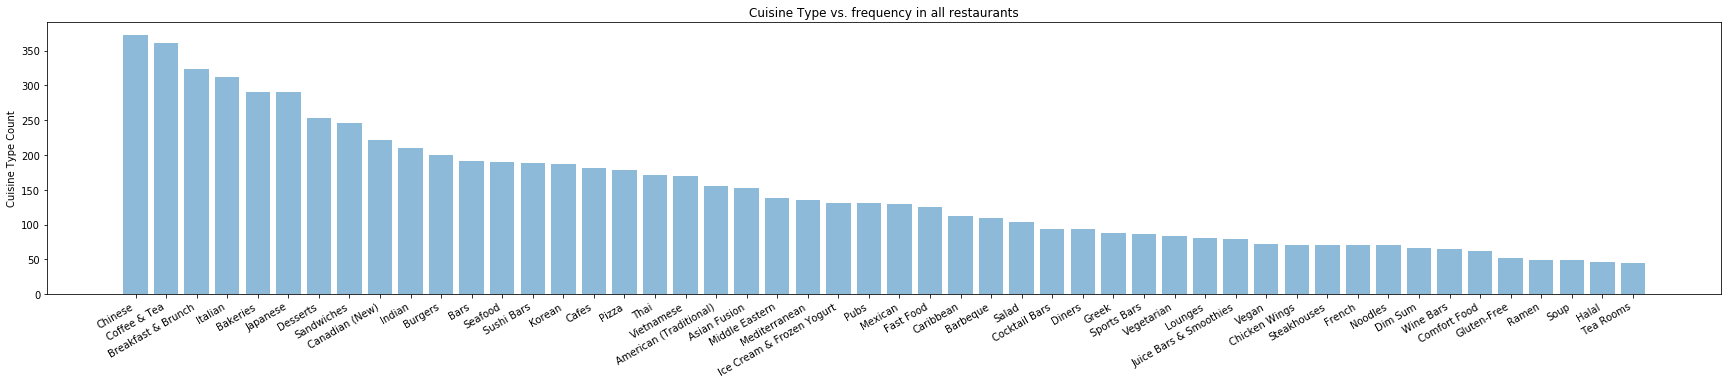

In [249]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,5))
labels = [cat for (cat,count) in sorted_catCount][:50]
y = [count for (cat,count) in sorted_catCount][:50]
x = np.arange(len(labels))

plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, labels, rotation=30, ha='right')
plt.ylabel('Cuisine Type Count')
plt.title('Cuisine Type vs. frequency in all restaurants')

plt.show()

In [202]:
IDdictList = ['idDictionary_dundasyonge.json', 'idDictionary_blooryonge.json', 'idDictionary_queenspadina.json',\
             'idDictionary_spadinadundas.json', 'idDictionary_bloorbathurst.json', 'idDictionary_yongefinch.json']
listOfBusiness = []

for intersection in IDdictList:
    load_Dict = loadDict(data_dir, intersection)
    load_Dict = {int(old_key): val for old_key, val in load_Dict.items()}
    matchedRes = [item for item, distance in load_Dict.items() if distance <=2.0]
    listOfBusiness.extend(matchedRes)
    listOfBusiness = list(set(listOfBusiness))

In [246]:
catCountDict1 = {}

#loop through business within the intersections 
for busiD in listOfBusiness:
    #Get list of category index 
    categoryIndexList = [catInd for catInd in I_C_matrix[busiD,:].nonzero()[1]]
    #loop through category id, get catgeory name
    for category in categoryIndexList:
        matchedCat = [cat for cat,cateInd in IC_dictionary.items() if cateInd==category][0]

        #Counting the frequency
        catCountDict1[matchedCat] = catCountDict1.get(matchedCat,0) +1

print(catCountDict1)
#Sort category count dictionary by category count
sorted_catCount1 = sorted(catCountDict1.items(), key=lambda kv: kv[1], reverse=True)

{'Cocktail Bars': 64, 'Bars': 84, 'Korean': 101, 'Soul Food': 3, 'Coffee & Tea': 133, 'Ramen': 33, 'Gluten-Free': 28, 'Pizza': 63, 'Salad': 57, 'Dive Bars': 22, 'Music Venues': 18, 'Filipino': 3, 'Vietnamese': 34, 'Vegetarian': 38, 'Mexican': 57, 'Irish': 7, 'Pubs': 48, 'Canadian (New)': 92, 'Thai': 47, 'Italian': 92, 'Burgers': 69, 'Sandwiches': 102, 'Tex-Mex': 4, 'Health Markets': 7, 'Juice Bars & Smoothies': 44, 'Latin American': 9, 'Nicaraguan': 1, 'American (Traditional)': 60, 'Chinese': 78, 'Seafood Markets': 3, 'Seafood': 58, 'Steakhouses': 18, 'Asian Fusion': 55, 'Japanese': 94, 'Fast Food': 44, 'Sushi Bars': 52, 'Breakfast & Brunch': 122, 'Singaporean': 1, 'Bistros': 7, 'Cafes': 77, 'Indian': 44, 'Middle Eastern': 36, 'Vegan': 38, 'Tapas Bars': 11, 'Modern European': 7, 'Wine Bars': 39, 'Dim Sum': 16, 'Beer Bar': 13, 'Sports Bars': 29, 'Bakeries': 74, 'Patisserie/Cake Shop': 9, 'Syrian': 1, 'Desserts': 93, 'Ice Cream & Frozen Yogurt': 59, 'Coffee Roasteries': 10, 'Barbeque': 3

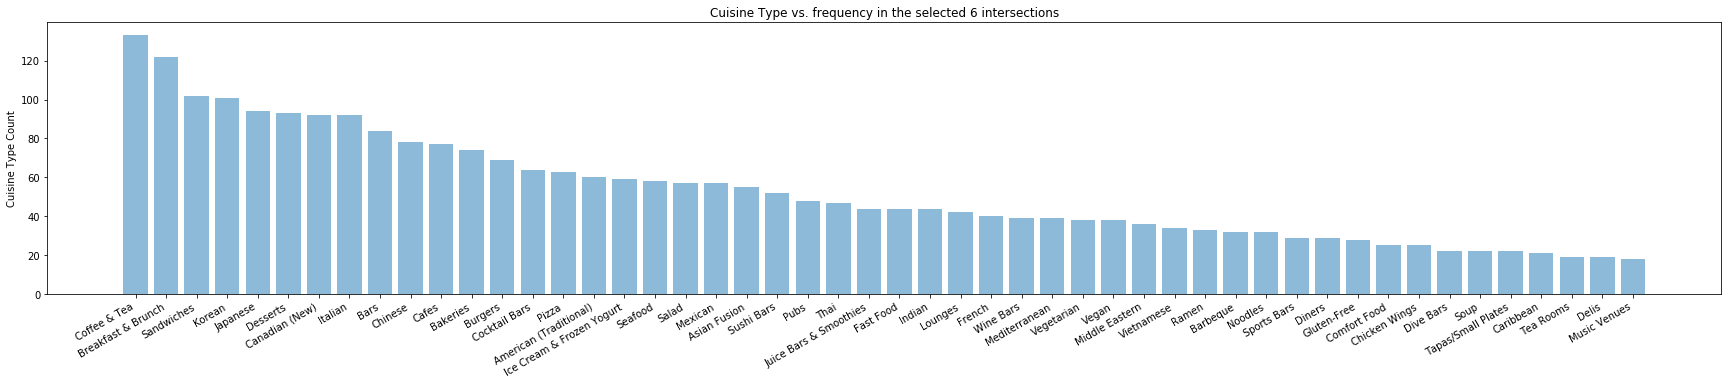

In [248]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,5))
labels = [cat for (cat,count) in sorted_catCount1][:50]
y = [count for (cat,count) in sorted_catCount1][:50]
x = np.arange(len(labels))

plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, labels, rotation=30, ha='right')
plt.ylabel('Cuisine Type Count')
plt.title('Cuisine Type vs. frequency in the selected 6 intersections')

plt.show()

In [294]:
df[df['business_id'] == 'HQpMwOOrGND3GaRqMNV9ig'].categories.unique()[0]

'Chinese'

In [297]:
#Select restaurants for initialization 
selectCatList = ['Chinese', 'Breakfast & Brunch', 'Italian', 'Japanese', 'Sushi Bars', 'Korean', 'Thai',\
                 'Mexican', 'Burgers', 'Seafood']

catResDict = {}
allbusNumId = [i for i in range(len(ID_dictionary_load))]
outOfRange = list(set(allbusNumId) - set(listOfBusiness))

for category in selectCatList:
    #find category id
    catId = IC_dictionary[category]
    #get the list of the businesses within this category, not in the selected intersections
    businessIndexList = [catInd for catInd in I_C_matrix[:,catId].nonzero()[0]]
    businessIndexList = list(set(businessIndexList).intersection(outOfRange))
    #Store all matching restaurants and their review count in this categories' corresponding dict
    candidateDict = {}
    for busId in businessIndexList:
        candidateDict[busId] = df[df['business_num_id'] == busId].review_count_y.unique()[0]
    
    catResDict[category] = candidateDict


for category in catResDict.keys():
    businessReviewDict = catResDict[category]
    sorted_businessReview = sorted(businessReviewDict.items(), key=lambda kv: kv[1], reverse=True)[:10]
    print('category:', category)
    print(sorted_businessReview)
    for busID, reviewCount in sorted_businessReview:
        businessId = df[df['business_num_id']==busID].business_id.unique()[0]
        businessName = df[df['business_num_id']==busID].name.unique()[0]
        categorys = df[df['business_num_id']==busID].categories.unique()[0]
        print('business num Id:', busID, 'business id:',businessId, 'business name:', businessName,\
              'review counts:', reviewCount, 'category:', categorys)

category: Chinese
[(2941, 692), (577, 343), (3015, 312), (3150, 305), (1428, 273), (3554, 242), (4567, 237), (854, 236), (2847, 214), (919, 206)]
business num Id: 2941 business id: _xAJZOKBMPOe47p1MphB2w business name: Fishman Lobster Clubhouse Restaurant review counts: 692 category: Chinese, Seafood
business num Id: 577 business id: 6ZsiLiSWGK2pgw6t3LfzNQ business name: Donburi review counts: 343 category: Japanese, Chinese
business num Id: 3015 business id: ae95XSsD37OQfOWF92GjNQ business name: Dragon Legend review counts: 312 category: Chinese, Buffets
business num Id: 3150 business id: cPXasVLtq_1gmuSg65TUfQ business name: Dragon Pearl Buffet review counts: 305 category: Buffets, Chinese
business num Id: 1428 business id: HQpMwOOrGND3GaRqMNV9ig business name: Jim Chai Kee review counts: 273 category: Chinese
business num Id: 3554 business id: hPTx2Y5e4Czbr21XcbDN8g business name: Mei Nung Beef Noodle House review counts: 242 category: Chinese, Taiwanese
business num Id: 4567 busine

business num Id: 352 business id: 3gdjVkNeUa9piW9H708Aig business name: The Olde Yorke review counts: 219 category: Seafood, Fish & Chips, British
business num Id: 1931 business id: OBG1j517k7aZRNC1HAL0TA business name: Fabbrica review counts: 187 category: Italian, Seafood, Pizza
business num Id: 1731 business id: LPCFfrQow0kl7EABuM7VDA business name: Inatei Japanese Cuisine review counts: 173 category: Japanese, Sushi Bars, Seafood
business num Id: 797 business id: 9Oc8UhYNarSisYM9SEBsKQ business name: Chop Steakhouse & Bar review counts: 161 category: Steakhouses, Seafood, Lounges


## API initialization

In [35]:
#Directly using global variables is fine, but you can only modify dictionary variables

app = Flask(__name__)
#Add resources to be much cleaner
api = Api(app)

#Initialize variable 
#Need to initialize to have only restaurants within 2.0km recommended, restaurants distance above 2.0 will be critiqued
#critique_distance = 2.0

#list of restaurant don't wanted, initialized as restaurants distance <2.0km
#critique_Res_list = [key for (key, value) in ID_dictionary.items() if value > critique_distance] 
#critique_Price_list = []
#ciritiqued_Rating_list = []
#list of categories don't wanted - Accumulated 
#critique_Cat_list = []

#Used to fall back, when user inputs are conflicted, modified during the critiquing process
#critiqued_Res_AccrdName_list= []
#critiqued_Res_AccrdCuisine_list = []
#critiqued_Res_AccrdPrice_list = []
#critiqued_Res_AccrdStar_list = []
#critiqued_Res_AccrdDistance_list = [key for (key, value) in ID_dictionary.items() if value > critique_distance] 

#Categories that explicitly wanted, ONLY 1 FOR NOW
#wanted_Category_index = -1

#Recommendation info
recommendIndex = 0

#To be initialized
ID_dictionary = {}

#Initial user item vector for critiquing process 
#current_user_item_predict = [item for item in test_user_item_predict if item not in critique_Res_list]

#Construct initial recommendation
#recBusinessJson = constructRestaurantDict(recommendIndex, current_user_item_predict,df,ID_dictionary)
#print(recBusinessJson)

#Following dictionaries are for retrieval 

priceDict = {
    1: 'inexpensive',
    2: 'moderately priced',
    3: 'premium priced',
    4: 'fine dining'
}
#Construct constant variables dictionary
variableDictionary = {
    'critique_distance' : 2.0,
    'wanted_Category_index': -1,
    'max_distance': 169
}

#A dictionary that stores all the lists related with the critiquing process
critiqueDictionary = {
    'critique_Res_list': [],
    'critique_Price_list':[],
    'critique_Cat_list': [],
    'ciritiqued_Rating_list':[],
    'critiqued_Res_AccrdStar_list': [],
    'critiqued_Res_AccrdCuisine_list':[],
    'critiqued_Res_AccrdPrice_list':[],
    'critiqued_Res_AccrdName_list': [],
    'critiqued_Res_AccrdDistance_list':[],
    'test_user_item_predict': [],
    'current_user_item_predict': []
    }

#Storing the current recommended restaurant
recommendResDict = {
        'recBusinessJson': None #recBusinessJson, to be initialized
}

intersectionDict= {'yonge_and_finch': 'idDictionary_yongefinch.json',
                   'bloor_and_bathurst': 'idDictionary_bloorbathurst.json',
                   'queen_and_spadina': 'idDictionary_queenspadina.json',
                   'bloor_and_yonge':'idDictionary_blooryonge.json',
                   'dundas_and_yonge': 'idDictionary_dundasyonge.json',
                   'spadina_and_dundas': 'idDictionary_spadinadundas.json'}

class ClearUp(Resource):
    #Request for resetting user preferences 
    def get(self):
        fallBackSetup(critiqueDictionary['critiqued_Res_AccrdName_list'], critiqueDistance=2.1)
        return {'You are Resetting the user set up': 'Not retrieving anything for you'}

class Initialize(Resource):
    def get(self):
        return {'You are calling a GET for set up:': 'Not retrieving anything for you'}
    
        #Post intersection {'init_key': intersection_name}
    def post(self):
        global ID_dictionary 
        global critiqueDictionary
        
        request_json  = request.get_json()

        intersectionString = request_json.get('init_key','none')
        filePath = ""
        #find intersection name, load ID_dictionary
        for intersection in intersectionDict:
            if intersectionString == intersection:
                filePath = intersectionDict[intersection]
            
        if not filePath:
            return {'request': request_json,
                   'message': 'you need to pass in valid intersection names'}
        
        #Create ID_dictionary 
        print(filePath)
        load_dict = loadDict(data_dir, filePath)
        load_dict = {int(old_key): val for old_key, val in load_dict.items()}
        ID_dictionary = load_dict.copy()
        
        #get_ID_dictionary(df,list(set(df['business_num_id'])),intersection).copy() 
        
        
        variableDictionary['maxDistance'] = max(ID_dictionary, key=ID_dictionary.get)
        #create initial critique restaurant list
        critique_Res_list = [key for (key, value) in ID_dictionary.items() if value > variableDictionary['critique_distance']] 
        critiqued_Res_AccrdDistance_list = critique_Res_list.copy()
        critiqueDictionary['critique_Res_list'] = critique_Res_list.copy()
        critiqueDictionary['critiqued_Res_AccrdDistance_list'] = critiqued_Res_AccrdDistance_list.copy()
        
        return {'You are calling a POST for set up, intersection point:': intersectionString}
    
    #Put user initial preferences to initialize the initial user recommendation 
    #Produces test_user_item_predict, computes the recommendation results for the new user 
    #request json {init_key: [business id list]}
    def put(self):
        global ID_dictionary 
        global critiqueDictionary
        
        request_json  = request.get_json()
        
        UserInitialResponse = {}
        
        #Get a list of business ids 
        businessIds = request_json.get('init_key','none')
        
        #Construct dictionary 
        for businessId in businessIds:
            UserInitialResponse[businessId] = 5
        
        #Construct the user item rating vector 
        userSetUpVector = constructUserItemVector(UserInitialResponse)
        #Get item recommendation for user 
        user_item_prediction_score = predict(userSetUpVector, 110, IK_similarity, item_similarity_en= True)[0]
        user_item_predict = prediction_oneHotEncode(user_item_prediction_score, userSetUpVector)
        #Get the user item prediction, put into dictionary 
        test_user_item_predict = list(user_item_predict[0])
        critiqueDictionary['test_user_item_predict'] = test_user_item_predict.copy()
        
        #Creates the rest -- waiting for put method to initialize user 
        current_user_item_predict = list(set(critiqueDictionary['test_user_item_predict']) - set(critiqueDictionary['critique_Res_list']))
        
        critiqueDictionary['current_user_item_predict'] = current_user_item_predict.copy()
        
        recBusinessJson = constructRestaurantDict(0, critiqueDictionary['current_user_item_predict']\
                                                  ,df,ID_dictionary)
                                
        recommendResDict['recBusinessJson'] = recBusinessJson
        
        return {'You are calling a PUT for set up, the user initialization you sent:': request_json}
    
class Business(Resource):

    def __init__(self):
        self.critique_Price_list = []
        self.countVar = 0
    
    def get(self):
        #return {'business name': data[0]['name']} # Fetches first column that is Employee ID
        return recommendResDict['recBusinessJson']
    
    def post(self):
        some_json  = request.get_json()
        #put json object for the critiquing process 
        #Return newly computed object 
        return {'You sent': some_json}, 201
    def put(self):
        start_time = time.time()
        
        #Get the request json
        request_json  = request.get_json()
        print('Input data:', request_json)
        
        #put json object for the critiquing process 
        critique_feature = request_json.get('feature', 'none')
        critique_posNeg = request_json.get('positiveOrNegative', 'none')
        critique_value = request_json.get('critiqueValue', 'none')
        if isinstance(critique_value, list):
            critique_value = critique_value[0]
        
        #Error Handling - Shouldn't trigger if json format passed in properly 
        if critique_feature == 'none':
            print('Critique Feature cannot be recognized')
        if critique_posNeg == 'none':
            print('Critique positive or negative category cannot be recognized')
        
        #Once user send this request, critique current item 
        #tempCritiqueRestList = critiqueDictionary['critique_Res_list'].copy()
        #tempCritiqueRestList.append(critiqueDictionary['current_user_item_predict'][recommendIndex])
        
        #Put back into the dictionary 
        critiqueDictionary['critique_Res_list'].append(critiqueDictionary['current_user_item_predict'][recommendIndex])
        critiqueDictionary['critiqued_Res_AccrdName_list'].append(critiqueDictionary['current_user_item_predict'][recommendIndex])
        
        
        #initialize additional text to be passed back
        additionalText = ''
        critiqueText = ''
        
        #temporary updated recommendation list
        tempRecommendList = []
        
        #Scenario 1 - Critique Restaurant name 
        if 'name' in critique_feature:
            
            print("Saving critiqued item: ", critiqueDictionary['current_user_item_predict'][recommendIndex])      
            
            critiqueText = "Critiquing the current displayed item..."
            
            #update critiqued restaurant list according to name
            #critiqueDictionary['critiqued_Res_AccrdName_list'] = updateList(critiqueDictionary['critiqued_Res_AccrdName_list'], \
            #                                                                critiqueDictionary['current_user_item_predict'][recommendIndex])
            
            critiqueDictionary['current_user_item_predict'] = critiqueDictionary['current_user_item_predict'][recommendIndex+1 :]
            
        #Scenario 2 - Negatively critique restaurant features 
        if ('cuisine' in critique_feature) and ('negative' in critique_posNeg):
            
            #Get current recommended restaurant cuisine type
            currentCuisineType = recommendResDict['recBusinessJson']['cuisine'].split(',')
            
            #Find the correct category name the user want to critique in current recommended item categories
            critiqueValue = [cuisine.strip() for cuisine in currentCuisineType if critique_value.strip().lower() in cuisine.lower()][0]
            
            #Retrieve critiquing category index
            critiquied_Cat_Index = IC_dictionary[critiqueValue]
            print('Saving negatively critiqued cuisine type:', critique_value, ', cuisine index: ', critiquied_Cat_Index)
            
            critiqueText = "Critiquing the cuisine type: %s ..." %critiqueValue
            
            #Save the newly critiqued cuisine type
            critiqueDictionary['critique_Cat_list'] = critiqueDictionary['critique_Cat_list'] + [critiquied_Cat_Index]
            
            #Handling extreme case - critique categories previously requested 
            if critiquied_Cat_Index == variableDictionary['wanted_Category_index']:
                #Reset wanted category index
                variableDictionary['wanted_Category_index'] = -1
                print('You are critiquing a cuisine type you previously requested\n Fall back to initial preference')
                additionalText = additionalText + '|You are critiquing a cuisine type you previously requested'
                
                #Restting the prediction list -.-? 
                critiqueDictionary['current_user_item_predict'] = \
                                        list(set(critiqueDictionary['test_user_item_predict']) \
                                             - set(critiqueDictionary['critique_Res_list']))

            #Find list of restaurants to filter out 
            critiquedItemsList = list(I_C_matrix.getcol(critiquied_Cat_Index).nonzero()[0])
            
            #Updating the critiqued items to list
            print('Saving critiqued items at index: ', critiquedItemsList[:5], '...')
            templist = critiqueDictionary['critique_Res_list'].copy()
            templist.extend(list(critiquedItemsList))
            
            #temporary updated recommend list 
            tempRecommendList = [item for item in critiqueDictionary['current_user_item_predict']\
                                          if item not in templist]
            
            #Check if exhausted list, if so clear out all restaurants 
            if exhaustFallBack(tempRecommendList):
                additionalText = additionalText +'| Could not retrieve restaurants matching current preferences, resetting all preferences'
                print('--FALLING BACK TO INITIAL PREFERENCE--')
                fallBackSetup(critiqued_Res_AccrdName_list=critiqueDictionary['critiqued_Res_AccrdName_list'], \
                              critiqueDistance=2.0)
            else:
                #Update critique restaurant list 
                critiqueDictionary['critique_Res_list'] = list(set(templist))

                #Update the list of restaurants critiqued by cuisin type
                templist = critiqueDictionary.get('critiqued_Res_AccrdCuisine_list',[]).copy()
                templist.extend(critiquedItemsList)
                critiqueDictionary['critiqued_Res_AccrdCuisine_list'] = list(set(templist))

                #Filter out critiqued items, sequence must remain the same, update current valid set 
                critiqueDictionary['current_user_item_predict'] = tempRecommendList.copy()

        
        #Scenario 3 - Positively critique restaurant cuisine type 
        if 'cuisine' in critique_feature and 'positive' in critique_posNeg:
            
            critiqueText = "Remembering cuisine preference: %s ..." %critique_value
            
            #Find the correct category within all the categories list - assuming exact word typed in 
            """Add ERROR HANDLING HERE"""
            positiveCritiquiCategory = [cuisine for cuisine in categoryList if \
                                        critique_value.strip().lower() in cuisine.lower()][0]
            
            #Retrieve cuisine type index, 1 number  
            positiveCritiquiedIndex = IC_dictionary[positiveCritiquiCategory]

            #Get the preferred category index, replace existing ones
            variableDictionary['wanted_Category_index'] = positiveCritiquiedIndex

            #Retrieve items/restaurants matching item category 
            matchedResList = list(I_C_matrix.getcol(positiveCritiquiedIndex).nonzero()[0])
            matchedResList = list(set(matchedResList) - set(critiqueDictionary['critique_Res_list']))
            print('matching list:', matchedResList[:10])
            
            #Check if user have previously critiqued - remove it 
            if positiveCritiquiedIndex in critiqueDictionary['critique_Cat_list']:
                addtionalText += 'You have previously critiqued the cuisine type, now adding back'
                templist = critiqueDictionary['critique_Cat_list']
                templist.remove(positiveCritiquiedIndex)
                critiqueDictionary['critique_Cat_list'] = templist

                #Update critiqued restaurant list according to cuisine type 
                templist = critiqueDictionary['critiqued_Res_AccrdCuisine_list']
                templist.remove(matchedResList)
                critiqueDictionary['critiqued_Res_AccrdCuisine_list'] = templist

                #UPDATE CRITIQUE RESTAURANT LIST 
                #In the matched restuarnt list and not critiqued under other criteria will be withdrawn from this list
                critiqueDictionary['critique_Res_list'] = [item for item in critiqueDictionary['test_user_item_predict']\
                                                           if item not in matchedResList or \
                                    item in list(set(critiqueDictionary['critiqued_Res_AccrdName_list']+ \
                                                     critiqueDictionary['critiqued_Res_AccrdCuisine_list']+\
                                                     critiqueDictionary['critiqued_Res_AccrdStar_list']+ \
                                                     critiqueDictionary['critiqued_Res_AccrdDistance_list']))]
            
            tempRecommendList = list(set(matchedResList) - set(critiqueDictionary['critique_Res_list']))
            
            #Check if exhausted recommendation list 
            if exhaustFallBack(tempRecommendList):
                additionalText = additionalText +'No restaurants match current user preference, disgarding preference for current iteration...'
            else:    
                #Update current valid set, make sure not in critiqued restaurant set 
                critiqueDictionary['current_user_item_predict'] = tempRecommendList.copy()
            
        #Scenario 4 - Negative critique restuarant price e.g. "I don't want expensive restaurants" OR positive "I want cheaper"
        #Scenario 5 - Positively critique restaurant price, "I want fine dining", wanting more expensive restaurant 
        if 'price' in critique_feature:
            
            #Get current price label range in 1 - 4
            currentPriceLabel = IP_dictionary[critiqueDictionary['current_user_item_predict'][recommendIndex]]
            
            #Get critique_price_list first
            templist = critiqueDictionary.get('critique_Price_list', []).copy()
            
            #Change critique value to default cheaper option 
            if critique_posNeg == 'negative':
                critique_value = 'cheaper'
            
            #Update critiqued price list
            if 'positive' in critique_posNeg and critique_value == 'more expensive':
                templist.extend([price for price in range(1,currentPriceLabel+1,1)])
                
            #Negative or positive, cheaper     
            else:     
                templist.extend([price for price in range(currentPriceLabel,5,1)])
            
            #update critiqued_price_list by puting it back to the dictionary
            critiqueDictionary['critique_Price_list'] = list(set(templist))

            #Check if critiqued all price range, if critiqued all price range 
            if len(critiqueDictionary['critique_Price_list']) == 4:
                
                #Cases where users intentionally exhaust the price list
                if currentPriceLabel==4 and critique_value == 'more expensive':
                    print('You have critiqued all price range, showing the most expensive options')
                    critiqueDictionary['critique_Price_list'] = [1,2,3]
                    #Send feedback to front end
                    additionalText = 'Showing the finest restaurant options'
                elif currentPriceLabel==1 and critique_value == 'cheaper':
                    print('You have critiqued all price range, showing the cheapest option')
                    critiqueDictionary['critique_Price_list'] = [2,3,4] 
                    additionalText = 'Showing the cheapest restaurant options'
                #Cases where users have seen all prices, and modify price preference
                elif 'positive' in critique_posNeg and critique_value == 'more expensive':
                    critiqueDictionary['critique_Price_list'] = [price for price in range(1,currentPriceLabel+1,1)]
                #Negative or positive, cheaper     
                else:     
                    critiqueDictionary['critique_Price_list']=[price for price in range(currentPriceLabel,5,1)]
                
                
                #Clear the previous critiqued restuarants based on price out of critiqued restuarant list 
                critiqueDictionary['critique_Res_list'] = [item for item in critiqueDictionary['test_user_item_predict'] if\
                                    item in list(set(critiqueDictionary['critiqued_Res_AccrdName_list'] + \
                                                     critiqueDictionary['critiqued_Res_AccrdCuisine_list']+\
                                                     critiqueDictionary['critiqued_Res_AccrdStar_list'] + \
                                                     critiqueDictionary['critiqued_Res_AccrdDistance_list']))]

                #Clear out the restuarants critiquied by price 
                critiqueDictionary['critiqued_Res_AccrdPrice_list'] = []
                     
            print('Critiqing price at range:', [priceDict[label] for label in critiqueDictionary['critique_Price_list']])
            
                  
            #Set message for front end
            critiqueText = 'Finding restaurants that are: ' 
                  
            tempPriceList = [1,2,3,4]
                  
            critiqueText += ",".join([priceDict[label] for label in list(set(tempPriceList) - set(critiqueDictionary['critique_Price_list']))])
            
            #Find the list of restaurants to critique 
            listCritiqueRestaurant = [key for (key, value) in IP_dictionary.items() if \
                                       value in critiqueDictionary['critique_Price_list']]
            
            #find temporary updated critique list    
            tempCritiqueList = updateExtendList(critiqueDictionary['critique_Res_list'], listCritiqueRestaurant)
            
            tempRecommendList = list(set(critiqueDictionary['current_user_item_predict']) - set(tempCritiqueList))
            
            #CHECK IF EXHAUSTED, if so clear out all restaurants 
            if exhaustFallBack(tempRecommendList):
                additionalText = additionalText +'No restaurants match current user preference, disgarding preference for current iteration...'
            
            else:
                #Update the critiqued restaurant list
                critiqueDictionary['critique_Res_list'] = tempCritiqueList.copy()

                #Record the list of restaurants critiqued so far based on price 
                critiqueDictionary['critiqued_Res_AccrdPrice_list'] = updateExtendList(critiqueDictionary['critiqued_Res_AccrdPrice_list'], \
                                                           listCritiqueRestaurant)
                
                #Updating the critiqued items to list
                print('Saving critiqued items at index: ', listCritiqueRestaurant[:5], '...')

                ##Update current valid set , filter out critiqued items, sequence must remain the same
                critiqueDictionary['current_user_item_predict'] = tempRecommendList.copy()
                
        #Scenario 6 negatively critique rating & positively critique rating: both goes up 
        #"I don't want ratings this low?" "I don't want restuarants with rating below XXX" "I want restaurants with rating above XXX"
        #I will critique the ratings below the current rating or specific rating 
        if 'rating' in critique_feature:
            currentRating = float(recommendResDict['recBusinessJson']['rating'])
            
            if critique_value.lower() == 'current_rating':
                critique_value = currentRating
        
            #Critiquing the restaurants that has ratings equal and below this restaurant 
            critiqueRes = [rating/10 for rating in range(0,int(float(critique_value)*10)+1,5)]
            critiqueDictionary['ciritiqued_Rating_list'] = updateExtendList(critiqueDictionary['ciritiqued_Rating_list'], \
                                                                           critiqueRes)
            #If critiqued all price
            if critiqueDictionary['ciritiqued_Rating_list'] == [price/10 for price in range(0,51,5)]:
                print('exhausted list, no better restaurants, recommending the finest restaurants')
                additionalText += '|Exhausted list, no better restaurants, recommending restaurants beyond current rating'

                #reset critiqued restaurant list 
                critiqueDictionary['critique_Res_list'] = [item for item in critiqueDictionary['test_user_item_predict'] if\
                                    item in list(set(critiqueDictionary['critiqued_Res_AccrdName_list']+\
                                                     critiqueDictionary['critiqued_Res_AccrdCuisine_list']+\
                                                     critiqueDictionary['critiqued_Res_AccrdPrice_list']+\
                                                     critiqueDictionary['critiqued_Res_AccrdDistance_list']))] 

                #Clear out the restuarants critiquied by rating 
                critiqueDictionary['critiqued_Res_AccrdStar_list'] = []
                critiqueDictionary['ciritiqued_Rating_list'] = [rating/10 for rating in range(0,int(currentRating*10+1),5)]

            print('critiquing restaurants at rating rangeing at:',critiqueDictionary['ciritiqued_Rating_list'])
            #additionalText += '| critiquing restaurants at rating rangeing at:'+str(critiqueDictionary['ciritiqued_Rating_list'])
            
            tempRatingList = [price/10 for price in range(0,51,5)]
            findRatingList = list(set(tempRatingList) - set(critiqueDictionary['ciritiqued_Rating_list']))
            critiqueText = 'Finding restaurants at rating in range: %s ~ %s' % \
                                                                (str(min(findRatingList)),\
                                                                str(max(findRatingList)))
            
            
            #Get the list of restaurants to critique
            listCritiqueRes = [key  for (key, value) in IS_dictionary.items() if \
                               value in critiqueDictionary['ciritiqued_Rating_list']]
            
            #CHECK EXHAUSTED - Check to see if user critique exhausts the recommendation list
            #Take a temporary list as updated critiquing list 
            tempCritiqueList = updateExtendList(critiqueDictionary['critique_Res_list'], listCritiqueRes)
            
            #Take a temporary list as updated recommendation list 
            tempRecommendList = list(set(critiqueDictionary['current_user_item_predict']) - set(tempCritiqueList))
            
            #Exhausted recommendation list
            if exhaustFallBack(tempRecommendList):
                additionalText += '|No restaurants match current user preference, disgarding preference for current iteration...'
            else:
                #Updating the critiqued items to list
                print('Saving critiqued items at index: ', listCritiqueRes[:5], '...')

                #Update the critiqued restaurant list
                critiqueDictionary['critique_Res_list'] = updateExtendList(critiqueDictionary['critique_Res_list'], listCritiqueRes)

                #Record those as well
                critiqueDictionary['critiqued_Res_AccrdStar_list'] = updateExtendList(critiqueDictionary['critiqued_Res_AccrdStar_list'], \
                                                                                      listCritiqueRes)
                #Update current valid set 
                critiqueDictionary['current_user_item_predict'] = list(set(critiqueDictionary['current_user_item_predict']) - \
                                                                   set(critiqueDictionary['critique_Res_list']))
        
        
        #Scenario #7 Critique on Distance, goes up or down, only say positive critiques. Want closer, further, or specific value 
        if 'distance' in critique_feature:
            
            #Get current distance
            currentDistance = float(recommendResDict['recBusinessJson']['distance'].strip('km'))
            
            #If want further distance restaurants
            if 'positive' in critique_posNeg and 'further' in critique_value.lower():
                print('Critiquing distance <=', currentDistance)
                
                critiqueText = 'Critiquing distance closer than %s km...' % str(currentDistance)
                
                #New requirements for restaurants to be critiqued
                listCritiquedRestaurant = [key for (key, value) in ID_dictionary.items() if value <= currentDistance]
                
            #Closer distance, critique value not empty 
            else:
                #specifiying a distance 
                if 'positive' in critique_posNeg and not 'closer' in critique_value.lower():
                    currentDistance = float(critique_value)

                print('Critiquing distance >=', currentDistance)
                critiqueText = 'Critiquing distance further than %s km...' % str(currentDistance)
                
                #New requirements for restaurants to be critiqued
                listCritiquedRestaurant = [busId for busId in critiqueDictionary['test_user_item_predict'] if ID_dictionary[busId] >= currentDistance]
                #listCritiquedRestaurant = [key for (key, value) in ID_dictionary.items() if value >= currentDistance]


            #Update critique restaurant list, only keep the ones that are critiqued under other features
            critiqueDictionary['critique_Res_list'] = [item for item in critiqueDictionary['test_user_item_predict'] if\
                                                      (item in list(set(listCritiquedRestaurant+\
                                                                        critiqueDictionary['critiqued_Res_AccrdPrice_list']+\
                                                                        critiqueDictionary['critiqued_Res_AccrdStar_list']+\
                                                                        critiqueDictionary['critiqued_Res_AccrdName_list']+\
                                                                        critiqueDictionary['critiqued_Res_AccrdCuisine_list'])))] 

            #Update list of restaurants critiqued by the restuarnt distance, entire replacement
            critiqueDictionary['critiqued_Res_AccrdDistance_list'] = listCritiquedRestaurant

            #Update initial valid restuarnt list
            critiqueDictionary['current_user_item_predict'] = list(set(critiqueDictionary['current_user_item_predict']) -\
                                                            set(critiqueDictionary['critique_Res_list']))
            
            #[item for item in critiqueDictionary['current_user_item_predict']\
            #                                                   if item not in critiqueDictionary['critique_Res_list']]

            #Handle case where critiqued everything, there's no restuarnt that satisfy all the critiques 
            if(len(critiqueDictionary['current_user_item_predict']) == 0):
                print('Exhausted sytem')

                #new_Distance= input('There\'s no restaurant that matches your preference within this area, please input a new larger distance')
                additionalText += 'No restaurants that matches your preference within this area, currently default back to 2.0km'
                new_Distance = 2.0
                
                listCritiquedRestaurant = [key for (key, value) in ID_dictionary.items() if value > new_Distance]

                #Restore original critiqued restaurants under distance feature 
                critiqueDictionary['critique_Res_list'] = [item for item in critiqueDictionary['test_user_item_predict'] if\
                                    (item in list(set(listCritiquedRestaurant + \
                                                      critiqueDictionary['critiqued_Res_AccrdPrice_list']+\
                                                      critiqueDictionary['critiqued_Res_AccrdStar_list']+\
                                                      critiqueDictionary['critiqued_Res_AccrdName_list']+\
                                                      critiqueDictionary['critiqued_Res_AccrdCuisine_list'])))]   
                #New critiquing restuarants
                critiqueDictionary['critiqued_Res_AccrdDistance_list'] = listCritiquedRestaurant

                #Update initial valid restuarnt list
                critiqueDictionary['current_user_item_predict'] = [item for item in critiqueDictionary['current_user_item_predict'] \
                                                                   if item not in critiqueDictionary['critique_Res_list']]
        
        #Full fall back 
        if(len(critiqueDictionary['current_user_item_predict']) ==0):
            fallBackSetup( critiqued_Res_AccrdName_list=critiqueDictionary['critiqued_Res_AccrdName_list'], \
                              critiqueDistance=2.0)
            additionalText += ' Ran out of recommendations at the end of the process, reset, filtered out seen restaurants'
            
            #If still no results
            if len(critiqueDictionary['current_user_item_predict']) ==0:
                fallBackSetup(critiqued_Res_AccrdName_list=[], \
                              critiqueDistance=2.0)
                additionalText += ' Clearing EVERYTHING'

        #Construct newly returning item
        return_Json = constructRestaurantDict(recommendIndex, critiqueDictionary['current_user_item_predict'],\
                                              df,ID_dictionary,additionalText, critiqueText)

        #Update restaurant information for the GET method
        recommendResDict['recBusinessJson'] = return_Json.copy()
        
        end_time = time.time()
        print('elapsed time:', round(end_time - start_time,2), 's')
        #Return newly computed object 
        return {'You_sent': request_json, 'Result': return_Json}, 201
            
api.add_resource(Business, '/business') # Route_1
api.add_resource(Initialize, '/initialization') #Route_2
api.add_resource(ClearUp, '/clearup') #Route_3

if __name__ == '__main__':
     app.run(port='5002')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5002/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Mar/2020 18:07:46] "POST /initialization HTTP/1.1" 200 -


idDictionary_spadinadundas.json


  2%|▏         | 78/4997 [00:00<00:06, 777.34it/s]

  (0, 2222)	5
  (0, 2979)	5
  (0, 3366)	5
  (0, 4334)	5
  (0, 4975)	5


100%|██████████| 4997/4997 [00:05<00:00, 835.34it/s]
127.0.0.1 - - [05/Mar/2020 18:08:18] "PUT /initialization HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2020 18:08:26] "GET /business HTTP/1.1" 200 -


Input data: {'feature': 'cuisine', 'positiveOrNegative': 'negative', 'critiqueValue': 'Bars'}
Saving negatively critiqued cuisine type: Bars , cuisine index:  190
Saving critiqued items at index:  [57, 176, 228, 345, 439] ...


127.0.0.1 - - [05/Mar/2020 18:08:39] "PUT /business HTTP/1.1" 201 -


elapsed time: 0.79 s
Input data: {'feature': 'cuisine', 'positiveOrNegative': 'negative', 'critiqueValue': 'Sports Bars'}
Saving negatively critiqued cuisine type: Sports Bars , cuisine index:  165
Saving critiqued items at index:  [65, 120, 189, 213, 245] ...


127.0.0.1 - - [05/Mar/2020 18:09:08] "PUT /business HTTP/1.1" 201 -


elapsed time: 0.77 s
Input data: {'feature': 'cuisine', 'positiveOrNegative': 'negative', 'critiqueValue': 'Coffee & Tea'}
Saving negatively critiqued cuisine type: Coffee & Tea , cuisine index:  45
Saving critiqued items at index:  [6, 12, 33, 38, 55] ...


127.0.0.1 - - [05/Mar/2020 18:09:20] "PUT /business HTTP/1.1" 201 -


elapsed time: 0.8 s
Input data: {'feature': 'distance', 'positiveOrNegative': ['positive'], 'critiqueValue': ['closer']}
Critiquing distance >= 1.4


127.0.0.1 - - [05/Mar/2020 18:09:37] "PUT /business HTTP/1.1" 201 -


elapsed time: 1.81 s


127.0.0.1 - - [05/Mar/2020 18:09:46] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'cuisine', 'positiveOrNegative': 'negative', 'critiqueValue': 'Hungarian'}
Saving negatively critiqued cuisine type: Hungarian , cuisine index:  95
Saving critiqued items at index:  [271, 400, 1149, 2057, 3870] ...
elapsed time: 0.09 s


127.0.0.1 - - [05/Mar/2020 18:09:56] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'cuisine', 'positiveOrNegative': 'positive', 'critiqueValue': 'Chinese'}
matching list: [644, 263, 265, 1034, 2699, 1161, 4114, 148, 1813, 1174]
elapsed time: 0.01 s


127.0.0.1 - - [05/Mar/2020 18:10:10] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'rating', 'positiveOrNegative': 'positive', 'critiqueValue': 'Current_rating'}
critiquing restaurants at rating rangeing at: [0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0]
Saving critiqued items at index:  [1039, 476, 4731, 1752, 253] ...
elapsed time: 0.04 s


127.0.0.1 - - [05/Mar/2020 18:11:03] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'rating', 'positiveOrNegative': 'positive', 'critiqueValue': 'Current_rating'}
critiquing restaurants at rating rangeing at: [0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0, 3.5]
Saving critiqued items at index:  [4103, 1390, 1039, 476, 1271] ...
elapsed time: 0.01 s


127.0.0.1 - - [05/Mar/2020 18:13:23] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'rating', 'positiveOrNegative': 'positive', 'critiqueValue': 'Current_rating'}
critiquing restaurants at rating rangeing at: [0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0]
Exhausted recommendation list, no matching restaurant after current critique
elapsed time: 0.03 s


127.0.0.1 - - [05/Mar/2020 18:14:06] "PUT /business HTTP/1.1" 201 -


Input data: {'feature': 'cuisine', 'positiveOrNegative': 'negative', 'critiqueValue': 'Vegetarian'}
Saving negatively critiqued cuisine type: Vegetarian , cuisine index:  184
Saving critiqued items at index:  [27, 36, 144, 239, 333] ...
elapsed time: 0.19 s


127.0.0.1 - - [05/Mar/2020 18:16:50] "POST /initialization HTTP/1.1" 200 -


idDictionary_dundasyonge.json


127.0.0.1 - - [05/Mar/2020 18:24:12] "POST /initialization HTTP/1.1" 200 -


idDictionary_blooryonge.json


In [ ]:
IC_dictionary.keys()

In [ ]:
df[df['business_num_id']=='4481']

In [ ]:
current_user_item_predict

In [ ]:
merge = listCritiquedRestaurant+critiqued_Res_AccrdPrice_list+ critiqued_Res_AccrdStar_list+critiqued_Res_AccrdName_list + critiqued_Res_AccrdCuisine_list
a = 4139
4139 not in critiqued_Res_AccrdDistance_list or 4139 in list(set(merge))

### Requests  Example

In [ ]:
from flask import Flask
from flask_restful import reqparse, abort, Api, Resource

app = Flask(__name__)
api = Api(app)

TODOS = {
    'todo1': {'task': 'build an API'},
    'todo2': {'task': '?????'},
    'todo3': {'task': 'profit!'},
}


def abort_if_todo_doesnt_exist(todo_id):
    if todo_id not in TODOS:
        abort(404, message="Todo {} doesn't exist".format(todo_id))

parser = reqparse.RequestParser()
parser.add_argument('task')


# Todo
# shows a single todo item and lets you delete a todo item
class Todo(Resource):
    def get(self, todo_id):
        abort_if_todo_doesnt_exist(todo_id)
        return TODOS[todo_id]

    def delete(self, todo_id):
        abort_if_todo_doesnt_exist(todo_id)
        del TODOS[todo_id]
        return '', 204

    def put(self, todo_id):
        args = parser.parse_args()
        task = {'task': args['task']}
        TODOS[todo_id] = task
        return task, 201


# TodoList
# shows a list of all todos, and lets you POST to add new tasks
class TodoList(Resource):
    def get(self):
        return TODOS

    def post(self):
        args = parser.parse_args()
        todo_id = int(max(TODOS.keys()).lstrip('todo')) + 1
        todo_id = 'todo%i' % todo_id
        TODOS[todo_id] = {'task': args['task']}
        return TODOS[todo_id], 201


## Actually setup the Api resource routing here

api.add_resource(TodoList, '/todos')
api.add_resource(Todo, '/todos/<todo_id>')


if __name__ == '__main__':
    app.run(debug=False)